In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import pandas as pd

from sklearn.metrics import confusion_matrix
import seaborn as sb

In [2]:
# define constant

FOLDER = 'datas/s40d30t1.6/'
GESTURES = ["topl", "twistl", "side", "downl", "twistr", "topr", "downr","unknown"]

DATA_POINT_PER_GESTURE = 30


SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
def plot_cm(actual, predict, size=(3,3)):
    conf_mat = confusion_matrix(np.argmax(actual, axis=1), np.argmax(predict, axis=1))

    plt.subplots(figsize=size)
    sb.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel("Actual labels")
    plt.ylabel("Predicted labels")

## Process data

In [4]:
inputs = []
outputs = []

ONE_HOTS = np.eye(len(GESTURES))

for i in range(len(GESTURES)):
    g = GESTURES[i]
    print(f"Processing {i} for gesture '{g}'.")
    
    output = ONE_HOTS[i]
    
    df = pd.read_csv(FOLDER + g + '.csv')
    num_recordings = int(df.shape[0] / DATA_POINT_PER_GESTURE)
    
    for j in range(num_recordings):
        tensor = []
        
        for k in range(DATA_POINT_PER_GESTURE):
            kk = j * DATA_POINT_PER_GESTURE + k
            
            tensor += [
                df['aX'][kk],
                df['aY'][kk],
                df['aZ'][kk],
                df['gX'][kk],
                df['gY'][kk],
                df['gZ'][kk],
#                 df['mX'][kk],
#                 df['mY'][kk],
#                 df['mZ'][kk],
            ]
            
        inputs.append(tensor)
        outputs.append(output)

Processing 0 for gesture 'topl'.
Processing 1 for gesture 'twistl'.
Processing 2 for gesture 'side'.
Processing 3 for gesture 'downl'.
Processing 4 for gesture 'twistr'.
Processing 5 for gesture 'topr'.
Processing 6 for gesture 'downr'.
Processing 7 for gesture 'unknown'.


In [5]:
# display(pd.DataFrame(inputs))

## Create train/validate/test datas

In [6]:
rdm_index = np.arange(len(inputs))
np.random.shuffle(rdm_index)

inputs = np.array(inputs)[rdm_index]
outputs = np.array(outputs)[rdm_index]

TRAIN_SPLIT = int(0.5 * len(inputs))
TEST_SPLIT = int(TRAIN_SPLIT + 0.25 * len(inputs))

i_train, i_validate, i_test = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
o_train, o_validate, o_test = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

# do this if data type invalid
i_train = tf.convert_to_tensor(i_train, dtype=tf.float32)
o_train = tf.convert_to_tensor(o_train, dtype=tf.float32)

i_validate = tf.convert_to_tensor(i_validate, dtype=tf.float32)
o_validate = tf.convert_to_tensor(o_validate, dtype=tf.float32)

i_test = tf.convert_to_tensor(i_test, dtype=tf.float32)

## Build and train model 1

In [7]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"

EPOCHS=100

In [8]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(GESTURES), activation='softmax')
])

model1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history1 = model1.fit(i_train, o_train,
                       epochs=EPOCHS, batch_size=1,
                   validation_data=(i_validate, o_validate))

Epoch 1/100
160/160 [==============================] - 1s 5ms/step - loss: 0.1049 - mae: 0.2105 - val_loss: 0.1021 - val_mae: 0.2097
Epoch 2/100
160/160 [==============================] - 1s 4ms/step - loss: 0.0938 - mae: 0.1965 - val_loss: 0.0902 - val_mae: 0.1920
Epoch 3/100
160/160 [==============================] - 1s 4ms/step - loss: 0.0793 - mae: 0.1754 - val_loss: 0.0808 - val_mae: 0.1742
Epoch 4/100
160/160 [==============================] - 1s 4ms/step - loss: 0.0655 - mae: 0.1508 - val_loss: 0.0653 - val_mae: 0.1540
Epoch 5/100
160/160 [==============================] - 1s 3ms/step - loss: 0.0557 - mae: 0.1338 - val_loss: 0.0549 - val_mae: 0.1317
Epoch 6/100
160/160 [==============================] - 1s 4ms/step - loss: 0.0464 - mae: 0.1154 - val_loss: 0.0498 - val_mae: 0.1224
Epoch 7/100
160/160 [==============================] - 1s 4ms/step - loss: 0.0410 - mae: 0.0993 - val_loss: 0.0432 - val_mae: 0.1141
Epoch 8/100
160/160 [==============================] - 1s 3ms/step - 

160/160 [==============================] - 0s 3ms/step - loss: 0.0092 - mae: 0.0162 - val_loss: 0.0050 - val_mae: 0.0122
Epoch 63/100
160/160 [==============================] - 1s 3ms/step - loss: 0.0069 - mae: 0.0132 - val_loss: 0.0073 - val_mae: 0.0152
Epoch 64/100
160/160 [==============================] - 1s 3ms/step - loss: 0.0096 - mae: 0.0169 - val_loss: 0.0080 - val_mae: 0.0178
Epoch 65/100
160/160 [==============================] - 0s 3ms/step - loss: 0.0059 - mae: 0.0124 - val_loss: 0.0084 - val_mae: 0.0161
Epoch 66/100
160/160 [==============================] - 1s 3ms/step - loss: 0.0069 - mae: 0.0143 - val_loss: 0.0028 - val_mae: 0.0102
Epoch 67/100
160/160 [==============================] - 0s 3ms/step - loss: 0.0064 - mae: 0.0143 - val_loss: 0.0108 - val_mae: 0.0287
Epoch 68/100
160/160 [==============================] - 1s 4ms/step - loss: 0.0094 - mae: 0.0160 - val_loss: 0.0244 - val_mae: 0.0467
Epoch 69/100
160/160 [==============================] - 1s 4ms/step - loss:

## Review model 1 performance

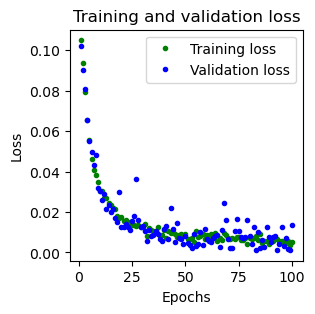

[3.0, 3.0]


In [9]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (3,3)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

### Mean absolute error

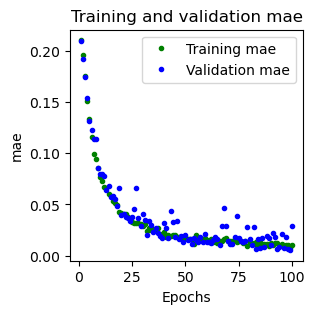

In [10]:
# graph of mean absolute error
plt.rcParams["figure.figsize"] = (3,3)
mae = history1.history['mae']
val_mae = history1.history['val_mae']
plt.plot(epochs, mae, 'g.', label='Training mae')
plt.plot(epochs, val_mae, 'b.', label='Validation mae')
plt.title('Training and validation mae')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()
plt.show()

## Verify model 1 with test data

3/3 [==============================] - 0s 2ms/step


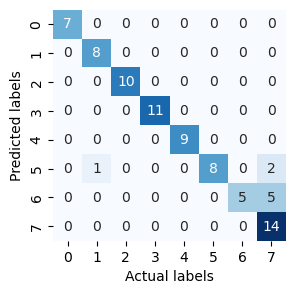

In [11]:
# use the model to predict the test inputs
predictions1 = model1.predict(i_test)

# print the predictions and the expected ouputs
# print("predictions =\n", np.round(predictions, decimals=3))
# print("actual =\n", o_test)

# Plot the predictions along with to the test data
# plt.clf()
# plt.title('Training data predicted vs actual values')
# plt.plot(np.arange(0, len(i_test)), o_test, 'b.', label='Actual')
# plt.plot(np.arange(0, len(i_test)), predictions, 'r.', label='Predicted')
# plt.show()

plot_cm(o_test, predictions1)

## Build and train model 2

In [12]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(len(GESTURES), activation='softmax')
])

loss_fn = tf.keras.losses.CategoricalCrossentropy()

model2.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

history2 = model2.fit(i_train, o_train,
                       epochs=EPOCHS, batch_size=1,
                   validation_data=(i_validate, o_validate))

Epoch 1/100
160/160 [==============================] - 1s 4ms/step - loss: 2.0591 - accuracy: 0.1187 - val_loss: 1.9399 - val_accuracy: 0.2250
Epoch 2/100
160/160 [==============================] - 1s 4ms/step - loss: 1.9104 - accuracy: 0.3313 - val_loss: 1.8181 - val_accuracy: 0.4125
Epoch 3/100
160/160 [==============================] - 1s 3ms/step - loss: 1.6770 - accuracy: 0.4563 - val_loss: 1.5690 - val_accuracy: 0.5125
Epoch 4/100
160/160 [==============================] - 1s 4ms/step - loss: 1.4312 - accuracy: 0.5562 - val_loss: 1.2679 - val_accuracy: 0.5750
Epoch 5/100
160/160 [==============================] - 1s 3ms/step - loss: 1.1648 - accuracy: 0.6313 - val_loss: 1.1098 - val_accuracy: 0.7125
Epoch 6/100
160/160 [==============================] - 0s 3ms/step - loss: 0.9911 - accuracy: 0.7188 - val_loss: 0.9931 - val_accuracy: 0.7250
Epoch 7/100
160/160 [==============================] - 1s 4ms/step - loss: 0.8431 - accuracy: 0.7437 - val_loss: 0.8300 - val_accuracy: 0.7500

Epoch 58/100
160/160 [==============================] - 0s 3ms/step - loss: 0.1343 - accuracy: 0.9625 - val_loss: 0.1878 - val_accuracy: 0.9125
Epoch 59/100
160/160 [==============================] - 0s 3ms/step - loss: 0.1364 - accuracy: 0.9625 - val_loss: 0.1013 - val_accuracy: 0.9750
Epoch 60/100
160/160 [==============================] - 0s 3ms/step - loss: 0.1171 - accuracy: 0.9625 - val_loss: 0.1163 - val_accuracy: 0.9625
Epoch 61/100
160/160 [==============================] - 0s 3ms/step - loss: 0.1460 - accuracy: 0.9500 - val_loss: 0.2650 - val_accuracy: 0.9000
Epoch 62/100
160/160 [==============================] - 0s 3ms/step - loss: 0.1321 - accuracy: 0.9500 - val_loss: 0.0951 - val_accuracy: 0.9500
Epoch 63/100
160/160 [==============================] - 0s 3ms/step - loss: 0.0935 - accuracy: 0.9750 - val_loss: 0.1983 - val_accuracy: 0.9250
Epoch 64/100
160/160 [==============================] - 0s 3ms/step - loss: 0.1227 - accuracy: 0.9625 - val_loss: 0.2044 - val_accuracy:

## Review model 2 performance

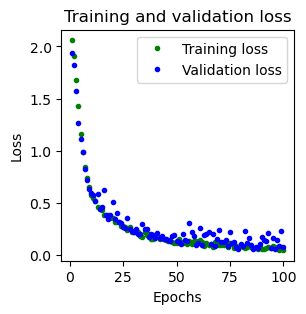

[3.0, 3.0]


In [13]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (3,3)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"]) 

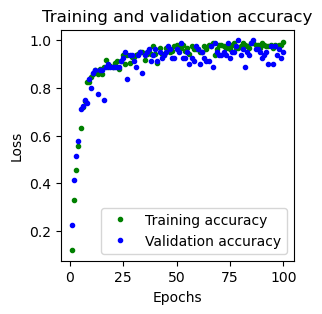

[3.0, 3.0]


In [14]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (3,3)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'g.', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b.', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"]) 

## Verify model 2 with test data

3/3 [==============================] - 0s 3ms/step


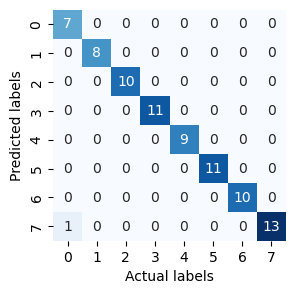

In [15]:
# use the model to predict the test inputs
predictions2 = model2.predict(i_test)

# print the predictions and the expected ouputs
# print("predictions =\n", np.round(predictions, decimals=3))
# print("actual =\n", o_test)

# Plot the predictions along with to the test data
# plt.clf()
# plt.title('Training data predicted vs actual values')
# plt.plot(np.arange(0, len(i_test)), o_test, 'b.', label='Actual')
# plt.plot(np.arange(0, len(i_test)), predictions, 'r.', label='Predicted')
# plt.show()

plot_cm(o_test, predictions2)

## Produce model file (.tflite)

Output both non-quantized and quantized model files


In [16]:
model=model2

TFLITE_FILE = 'tflite/gesture_model.tflite'
TFLITE_FILE_Q = 'tflite/gesture_model_q.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

open(TFLITE_FILE, "wb").write(tflite_model)


converter_q = tf.lite.TFLiteConverter.from_keras_model(model)
converter_q.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_dataset_generator():
 # each scalar value inside a 2D array that is wrapped in a list
 for value in inputs:
     yield [np.array(value, dtype=np.float32, ndmin=2)]

converter_q.representative_dataset = representative_dataset_generator
tflite_model_q = converter_q.convert()

open(TFLITE_FILE_Q, "wb").write(tflite_model_q)


# Review size difference
basic_model_size = os.path.getsize(TFLITE_FILE)
print("Basic model is %d bytes" % basic_model_size)

basic_model_size_q = os.path.getsize(TFLITE_FILE_Q)
print("Quantized model is %d bytes" % basic_model_size_q)

INFO:tensorflow:Assets written to: C:\Users\cheew\AppData\Local\Temp\tmp_odpzvdi\assets
INFO:tensorflow:Assets written to: C:\Users\cheew\AppData\Local\Temp\tmphge6deor\assets


INFO:tensorflow:Assets written to: C:\Users\cheew\AppData\Local\Temp\tmphge6deor\assets


Basic model is 27948 bytes
Quantized model is 9480 bytes


C:\Users\cheew\anaconda3\envs\tf\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


## Verify the interpreter (.tflite)

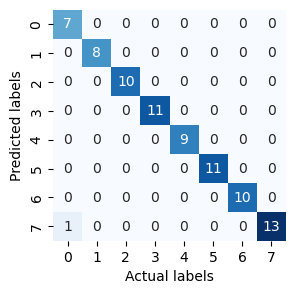

In [17]:
_model = tf.lite.Interpreter(TFLITE_FILE)

_model.allocate_tensors()

_model_input_index = _model.get_input_details()[0]['index']
_model_output_index = _model.get_output_details()[0]['index']

_model_predictions = []

for i in i_test:
    # write the value to the input tensor
    i_tensor = tf.convert_to_tensor([i], dtype=tf.float32)
    _model.set_tensor(_model_input_index, i_tensor)
    # run inference
    _model.invoke()
    # read the prediction from the output tensor
    _model_predictions.append(_model.get_tensor(_model_output_index)[0])

# # print the predictions and the expected ouputs
# print("model predictions =\n", np.round(_model_predictions, decimals=3))
# print("actual =\n", o_test)
plot_cm(o_test, _model_predictions)

## Verify the quantized interpreter (.tflite)

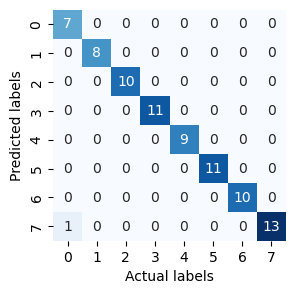

In [18]:
_model_q = tf.lite.Interpreter(TFLITE_FILE_Q)

_model_q.allocate_tensors()

_model_q_input_index = _model_q.get_input_details()[0]['index']
_model_q_output_index = _model_q.get_output_details()[0]['index']

_model_q_predictions = []

for i in i_test:
    # write the value to the input tensor
    i_tensor = tf.convert_to_tensor([i], dtype=tf.float32)
    _model_q.set_tensor(_model_q_input_index, i_tensor)
    # run inference
    _model_q.invoke()
    # read the prediction from the output tensor
    _model_q_predictions.append(_model_q.get_tensor(_model_q_output_index)[0])

# print the predictions and the expected ouputs
# print("quantized model predictions =\n", np.round(_model_q_predictions, decimals=3))
# print("actual =\n", o_test)
plot_cm(o_test, _model_q_predictions)

## Produce the model header file

In [19]:
# to run below command, ensure jupyter notebook is launched under bash terminal (eg. git bash, linux terminal)

HEADER_FILE = '../ble_client/gesture_model.h'
HEADER_FILE_Q = '../ble_client/gesture_model_q.h'
# based model header file
str1 = "const unsigned char {} [] = {{".format('gesture_model')
str2 = "};"

!echo {str1}  > {HEADER_FILE}
!cat {TFLITE_FILE} | xxd -i >> {HEADER_FILE}
!echo {str2} >> {HEADER_FILE}

# quantized model header file
str3 = "const unsigned char {} [] = {{".format('gesture_model_q')

!echo {str3}  > {HEADER_FILE_Q}
!cat {TFLITE_FILE_Q} | xxd -i >> {HEADER_FILE_Q}
!echo {str2} >> {HEADER_FILE_Q}